In [2]:
import torch 
import torch.nn as nn
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST

In [3]:
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])
dataset = FashionMNIST('', train = True, download = True, transform = transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

In [5]:
dataset[0][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
        nn.Linear(110, 256),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(1024, 784),
        nn.Tanh())
        
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
        nn.Linear(794, 1024),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(.3),  
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid()
        )
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [11]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [26]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()

In [24]:
def discriminator_train_step(batch_size, discriminator, generator
                         , d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item()

Starting epoch 0...
g_loss: 4.270613193511963, d_loss: 0.16745731234550476


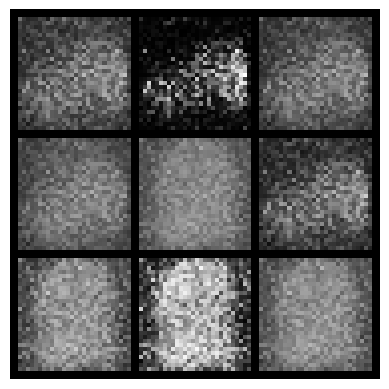

Starting epoch 1...
g_loss: 4.13987922668457, d_loss: 0.3865876793861389


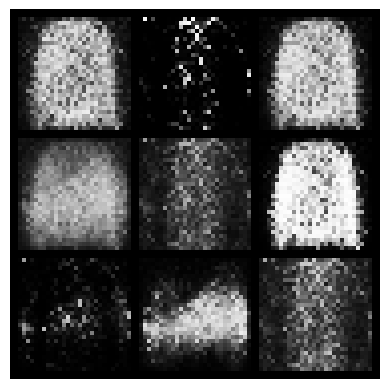

Starting epoch 2...
g_loss: 2.7348103523254395, d_loss: 0.5126195549964905


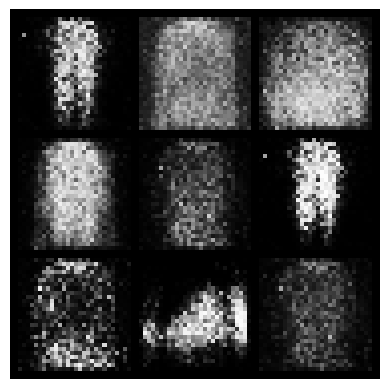

Starting epoch 3...
g_loss: 2.6415750980377197, d_loss: 0.3345714211463928


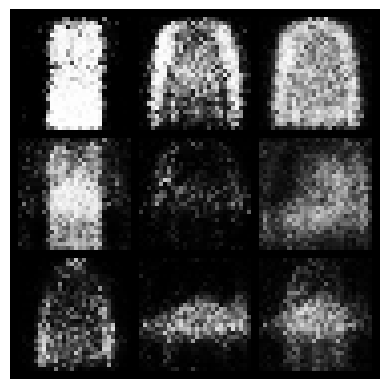

Starting epoch 4...
g_loss: 3.8433444499969482, d_loss: 0.33747759461402893


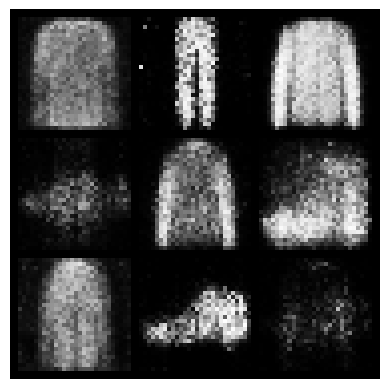

Starting epoch 5...
g_loss: 2.7565126419067383, d_loss: 0.5584820508956909


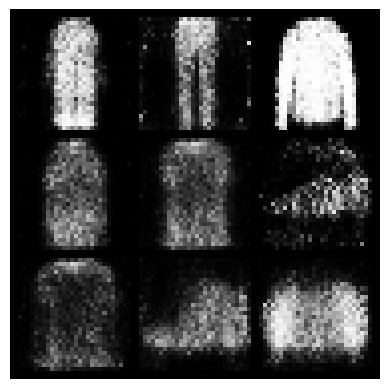

Starting epoch 6...
g_loss: 2.301656723022461, d_loss: 0.4845775067806244


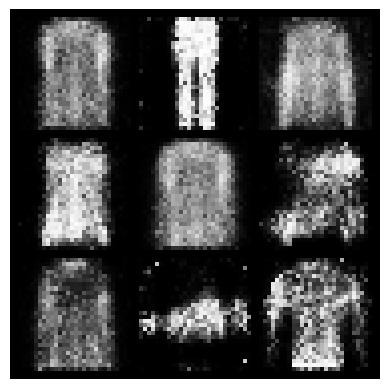

Starting epoch 7...
g_loss: 1.7211157083511353, d_loss: 0.800247848033905


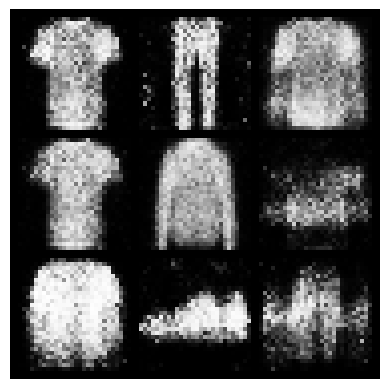

Starting epoch 8...
g_loss: 2.379169225692749, d_loss: 0.692552924156189


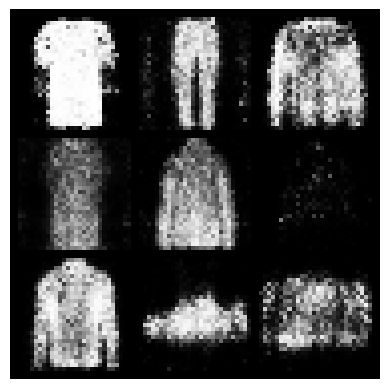

Starting epoch 9...
g_loss: 2.084482192993164, d_loss: 0.7718300819396973


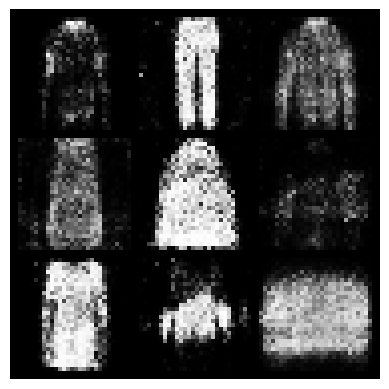

Starting epoch 10...
g_loss: 1.8436529636383057, d_loss: 0.763486385345459


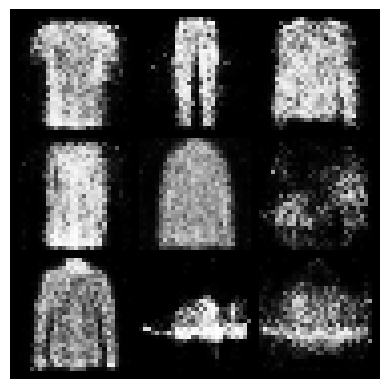

Starting epoch 11...
g_loss: 1.542518973350525, d_loss: 0.814151406288147


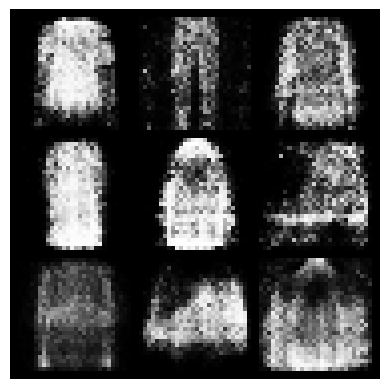

Starting epoch 12...
g_loss: 1.7354607582092285, d_loss: 0.7596752047538757


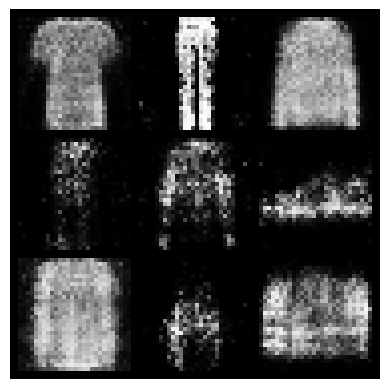

Starting epoch 13...
g_loss: 1.5125465393066406, d_loss: 0.7521491050720215


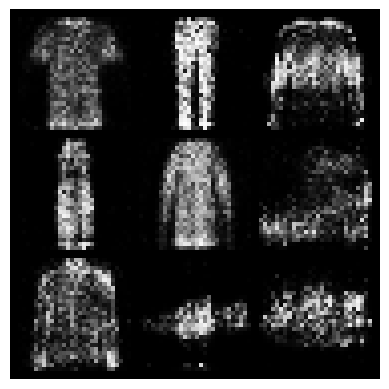

Starting epoch 14...
g_loss: 1.430638074874878, d_loss: 1.0022746324539185


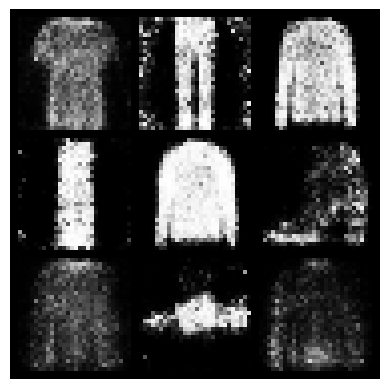

Starting epoch 15...
g_loss: 1.5159310102462769, d_loss: 0.945854127407074


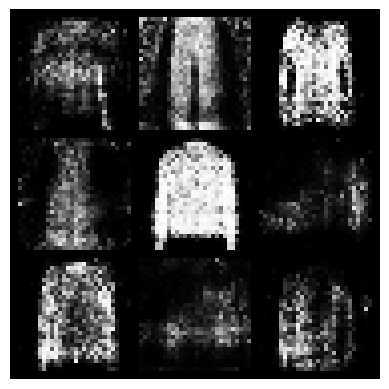

Starting epoch 16...
g_loss: 1.5523792505264282, d_loss: 0.8451008796691895


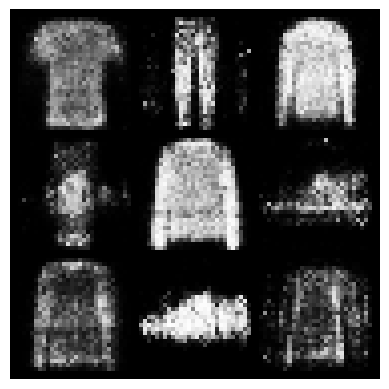

Starting epoch 17...
g_loss: 1.6628785133361816, d_loss: 0.8278768062591553


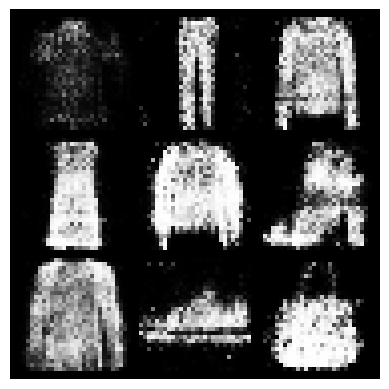

Starting epoch 18...
g_loss: 1.4742698669433594, d_loss: 0.8285281658172607


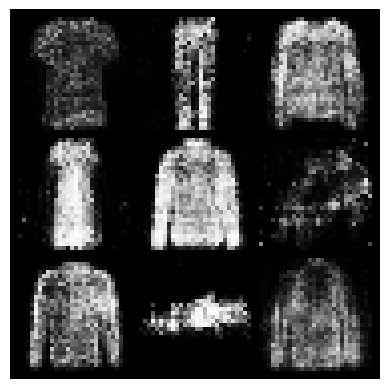

Starting epoch 19...
g_loss: 1.5895357131958008, d_loss: 0.7803112268447876


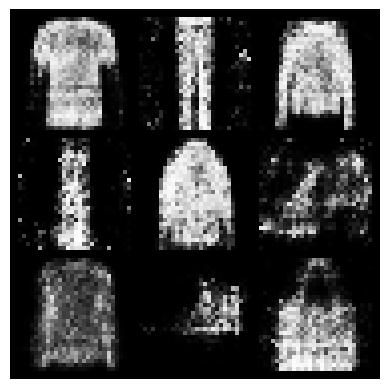

Starting epoch 20...
g_loss: 1.1941746473312378, d_loss: 0.8363437652587891


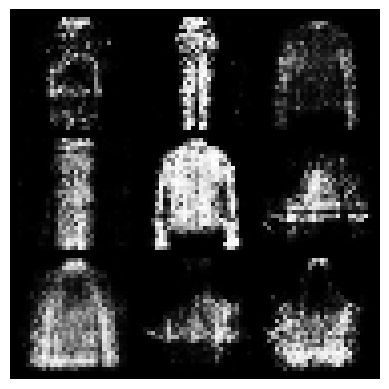

Starting epoch 21...
g_loss: 1.1513164043426514, d_loss: 0.84098881483078


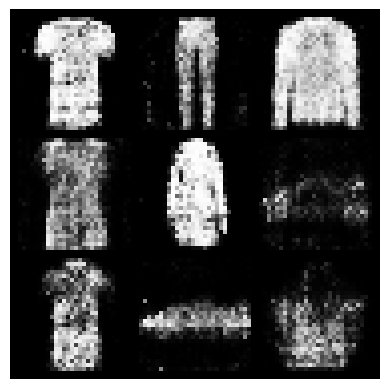

Starting epoch 22...
g_loss: 1.2905404567718506, d_loss: 1.128566026687622


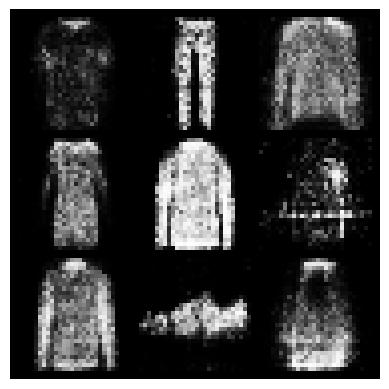

Starting epoch 23...
g_loss: 1.597684383392334, d_loss: 0.8971561193466187


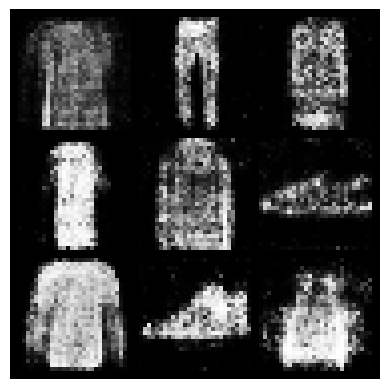

Starting epoch 24...
g_loss: 1.1628865003585815, d_loss: 1.0629899501800537


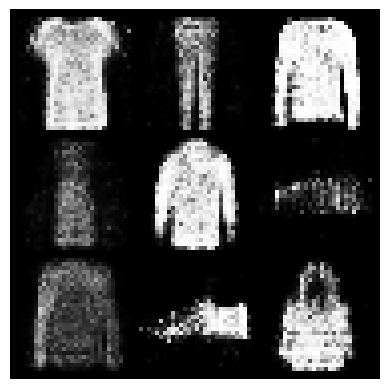

Starting epoch 25...
g_loss: 1.1996043920516968, d_loss: 0.9261305332183838


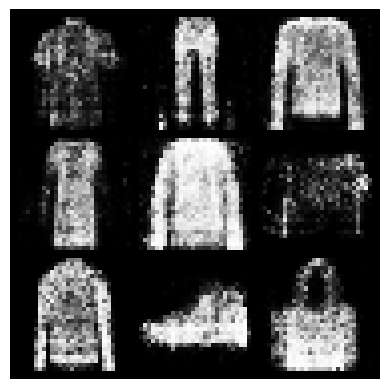

Starting epoch 26...
g_loss: 1.0842747688293457, d_loss: 1.200444221496582


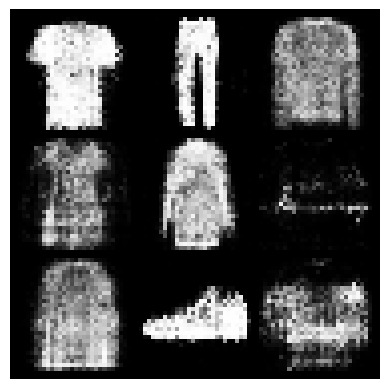

Starting epoch 27...
g_loss: 1.0992634296417236, d_loss: 1.1101183891296387


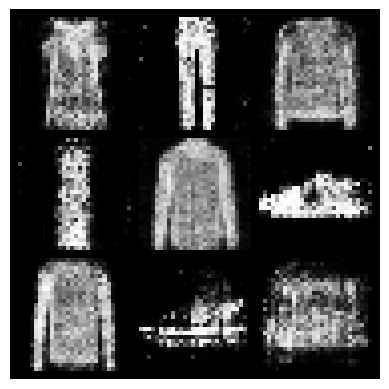

Starting epoch 28...
g_loss: 1.038184404373169, d_loss: 1.283586025238037


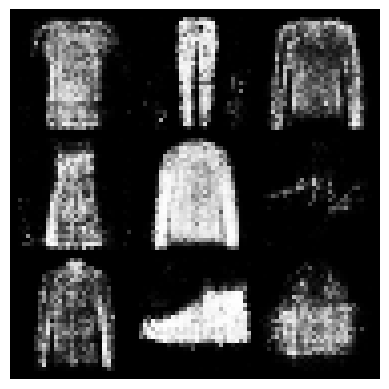

Starting epoch 29...
g_loss: 1.1358534097671509, d_loss: 1.2057700157165527


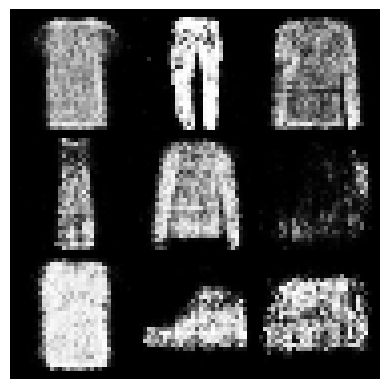

In [27]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator, generator, d_optimizer, criterion, real_images, labels)
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    
    z = Variable(torch.randn(9, 100)).to(device)
    labels = Variable(torch.LongTensor(np.arange(9))).to(device)
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True)\
                .permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

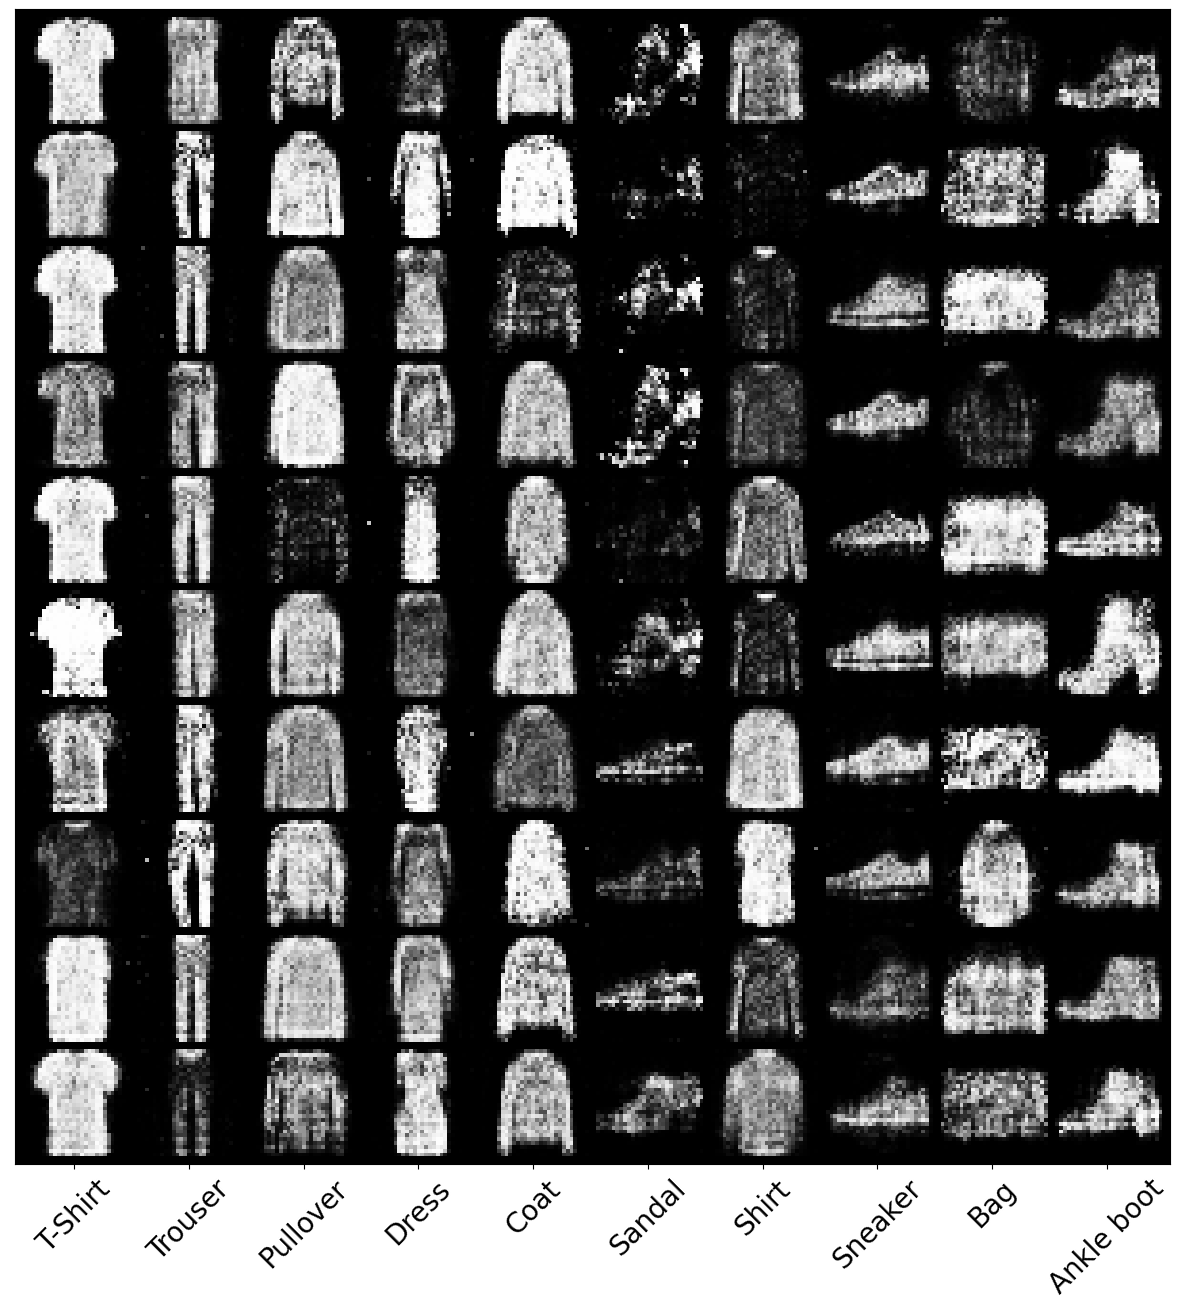

In [28]:
label_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat'
               , 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
z = Variable(torch.randn(100, 100)).to(device)
labels = Variable(torch.LongTensor([i for _ in range(10) for i 
                                    in range(10)])).to(device)

# 生成圖像
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True)\
                            .permute(1,2,0).numpy()

# 顯示圖像
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
plt.yticks([])
plt.xticks(np.arange(15, 300, 30), label_names, 
           rotation=45, fontsize=20);